<a href="https://colab.research.google.com/github/meer-1/cv-project/blob/main/Image_compression_with_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 encoder_dense_1 (Dense)     (None, 1000)              3073000   
                                                                 
 encoder_leakyrelu_1 (Leaky  (None, 1000)              0         
 ReLU)                                                           
                                                                 
 encoder_dense_2 (Dense)     (None, 50)                50050     
                                                                 
 encoder_output (LeakyReLU)  (None, 50)                0         
                                                     

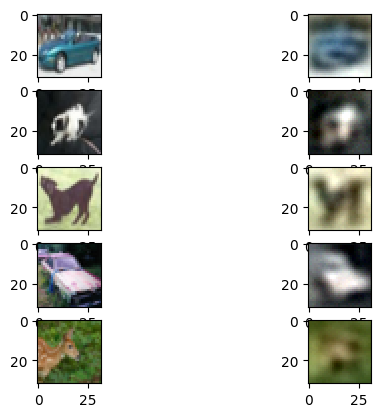

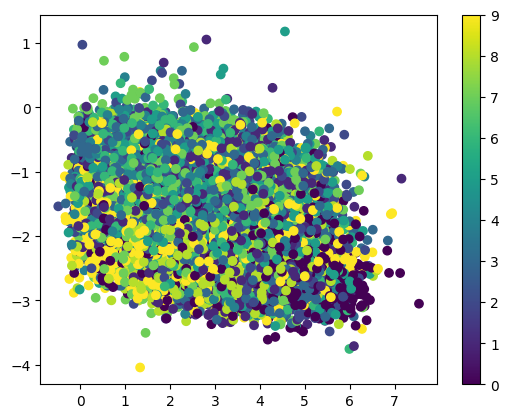

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets.cifar10 as cifar10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Encoder
input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 with 3 color channels
x = layers.Input(shape=input_shape, name="encoder_input")
x_flat = layers.Flatten()(x)

encoder_dense_layer1 = layers.Dense(units=1000, name="encoder_dense_1")(x_flat)  # Larger number of units due to RGB
encoder_activ_layer1 = layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = layers.Dense(units=50, name="encoder_dense_2")(encoder_activ_layer1)  # Adjusted bottleneck
encoder_output = layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

# Decoder
decoder_input = layers.Input(shape=(50), name="decoder_input")

decoder_dense_layer1 = layers.Dense(units=1000, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = layers.Dense(units=3072, name="decoder_dense_2")(decoder_activ_layer1)  # 32*32*3
decoder_flat_output = layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)
decoder_output = layers.Reshape((32, 32, 3))(decoder_flat_output)

decoder = models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

# Autoencoder
ae_input = layers.Input(shape=input_shape, name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

# RMSE
def rmse(y_true, y_predict):
    return tf.keras.backend.mean(tf.keras.backend.square(y_true - y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=0.0005))

# Preparing CIFAR-10 Dataset
(x_train_orig, y_train), (x_test_orig, y_test) = cifar10.load_data()  # CIFAR-10 is a dataset of RGB images
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

# Training AE
ae.fit(x_train_orig, x_train_orig, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test_orig, x_test_orig))

encoded_images = encoder.predict(x_train_orig)
decoded_images = decoder.predict(encoded_images)

num_images_to_show = 5
plt.figure()
for i in range(num_images_to_show):
    plot_ind = i * 2 + 1
    rand_ind = np.random.randint(0, len(x_train_orig))
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_train_orig[rand_ind], cmap="viridis")  # Original image
    plt.subplot(num_images_to_show, 2, plot_ind + 1)
    plt.imshow(decoded_images[rand_ind], cmap="viridis")  # Decoded image

plt.show()

# Plotting the encoded 2D representations
plt.figure()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=y_train[:, 0], cmap='viridis')
plt.colorbar()
plt.show()


Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)       

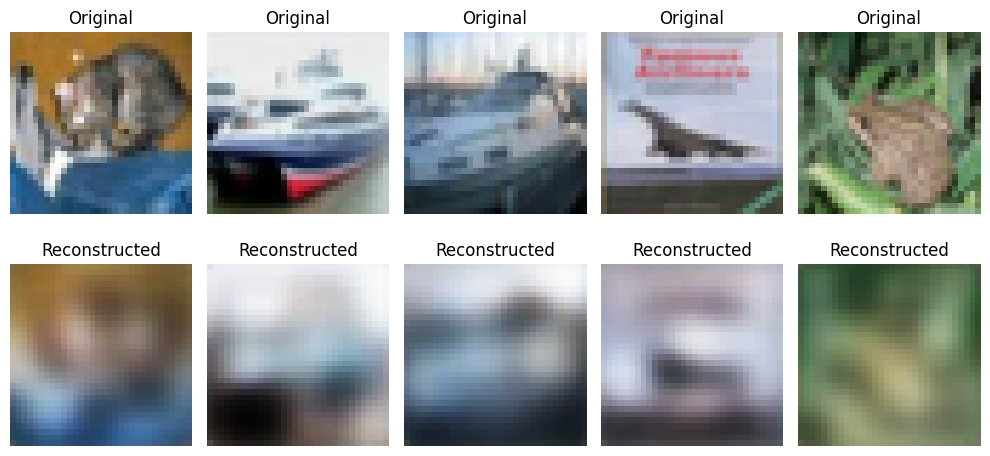

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets.cifar10 as cifar10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Encoder with Convolutional Layers
input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 with 3 color channels
x = layers.Input(shape=input_shape, name="encoder_input")

# Convolutional layers with downsampling
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)  # Output shape should be 4x4x128

# Flatten and reduce to a bottleneck
encoder_flat = layers.Flatten()(pool3)
encoder_output = layers.Dense(64, activation='relu')(encoder_flat)  # Bottleneck

encoder = models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

# Decoder with Convolutional Layers
decoder_input = layers.Input(shape=(64), name="decoder_input")  # Bottleneck size

decoder_dense = layers.Dense(4 * 4 * 128, activation='relu')(decoder_input)
decoder_reshape = layers.Reshape((4, 4, 128))(decoder_dense)

# Convolutional layers with upsampling
upsample1 = layers.UpSampling2D((2, 2))(decoder_reshape)
deconv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(upsample1)

upsample2 = layers.UpSampling2D((2, 2))(deconv1)
deconv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(upsample2)

upsample3 = layers.UpSampling2D((2, 2))(deconv2)
decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(upsample3)  # Final output

decoder = models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

# Autoencoder
ae_input = layers.Input(shape=input_shape, name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

# RMSE
def rmse(y_true, y_predict):
    return tf.keras.backend.mean(tf.keras.backend.square(y_true - y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=0.0005))

# Preparing CIFAR-10 Dataset
(x_train_orig, y_train), (x_test_orig, y_test) = cifar10.load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

# Training Autoencoder
ae.fit(x_train_orig, x_train_orig, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test_orig, x_test_orig))

# Visualizing Original and Reconstructed Images
decoded_images = ae.predict(x_test_orig)

plt.figure(figsize=(10, 5))
num_images_to_show = 5
for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(x_test_orig[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(decoded_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Standford dog dataset**

In [ ]:
# Install required libraries
!pip install tensorflow tensorflow-datasets matplotlib


100%|██████████| 170498071/170498071 [00:11<00:00, 15000441.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/1], Train Loss: 0.0318, Val Loss: 0.0155


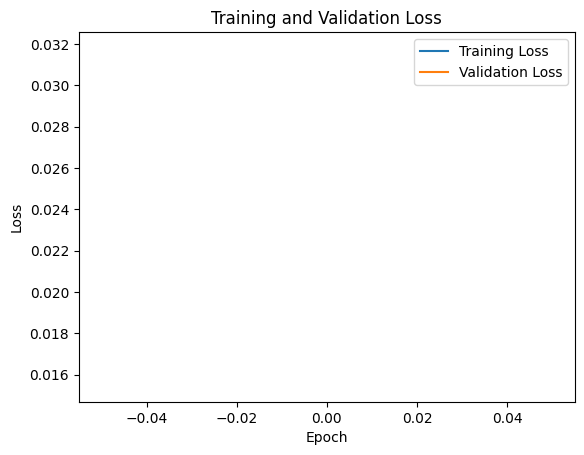

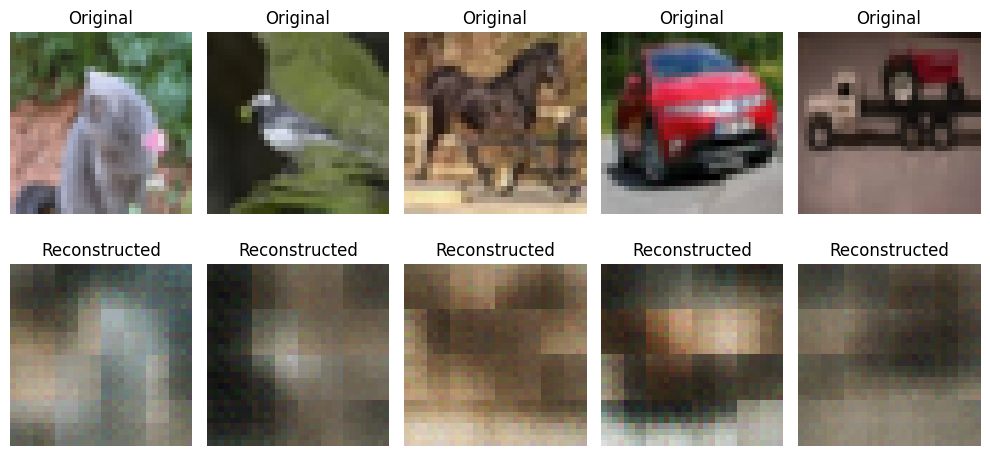

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define RMSE loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

# Define a function for plotting training and validation loss
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 1
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(train_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plotting loss curves
plot_loss(train_loss_history, val_loss_history)

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(train_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define RMSE loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

# Define a function for plotting training and validation loss
def plot_loss(train_loss, val_loss, test_loss=None):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.show()



In [ ]:

from torchsummary import summary
# Create an instance of the model
model = Autoencoder()
# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
  ConvTranspose2d-12           [-1, 64, 16, 16]          73,792
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

100%|██████████| 170498071/170498071 [00:02<00:00, 83774018.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/2], Train Loss: 0.1736, Val Loss: 0.1533
Epoch [2/2], Train Loss: 0.1497, Val Loss: 0.1496
Test Loss: 0.1453


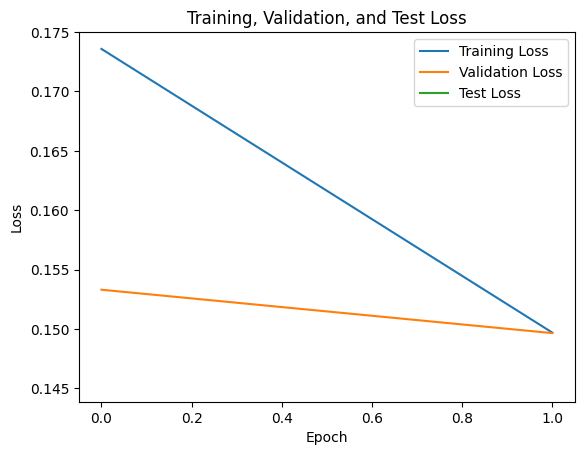

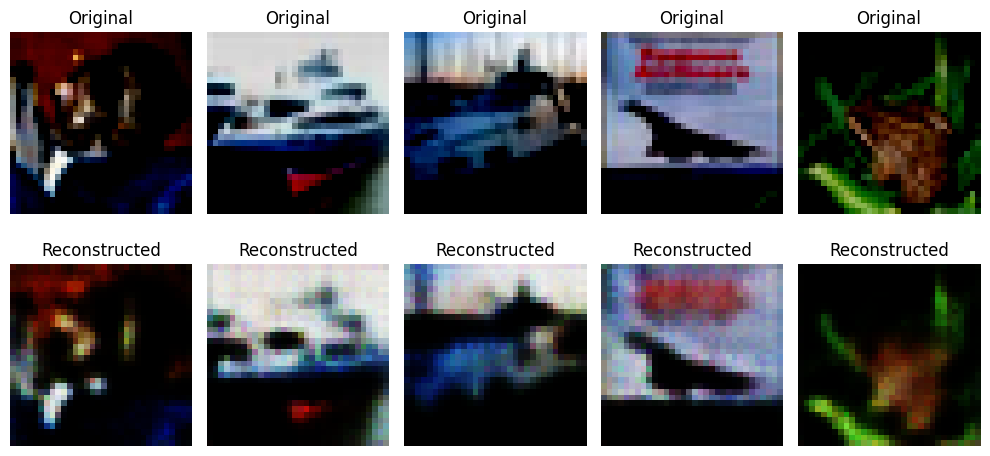

In [ ]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms without augmentation for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Define data transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set into training and validation sets
# Using a 80-20 split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 2
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print("Input size:", inputs.size())
        #print("Output size:", outputs.size())
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Testing loop

torch.save(model.state_dict(), 'autoencoder_model.pth')


test_loss_history = []

model.eval()
with torch.no_grad():
    test_loss = 0.0
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)
    test_loss = test_loss / len(test_loader.dataset)
    test_loss_history.append(test_loss)

print(f'Test Loss: {test_loss:.4f}')

# Plotting loss curves
plot_loss(train_loss_history, val_loss_history, test_loss_history)

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


##code with early stopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Train Loss: 0.1735, Val Loss: 0.1508
Epoch [2/20], Train Loss: 0.1499, Val Loss: 0.1474
Epoch [3/20], Train Loss: 0.1478, Val Loss: 0.1461
Epoch [4/20], Train Loss: 0.1467, Val Loss: 0.1457
Epoch [5/20], Train Loss: 0.1461, Val Loss: 0.1448
Epoch [6/20], Train Loss: 0.1456, Val Loss: 0.1444
Epoch [7/20], Train Loss: 0.1453, Val Loss: 0.1441
Epoch [8/20], Train Loss: 0.1451, Val Loss: 0.1441
Epoch [9/20], Train Loss: 0.1448, Val Loss: 0.1437
Epoch [10/20], Train Loss: 0.1446, Val Loss: 0.1436
Epoch [11/20], Train Loss: 0.1445, Val Loss: 0.1433
Epoch [12/20], Train Loss: 0.1445, Val Loss: 0.1435
Epoch [13/20], Train Loss: 0.1443, Val Loss: 0.1434
Epoch [14/20], Train Loss: 0.1442, Val Loss: 0.1432
Epoch [15/20], Train Loss: 0.1441, Val Loss: 0.1432
Epoch [16/20], Train Loss: 0.1440, Val Loss: 0.1430
Epoch [17/20], Train Loss: 0.1440, Val Loss: 0.1429
Epoch [18/20], Train Loss: 0.1439, Val Loss: 0.14

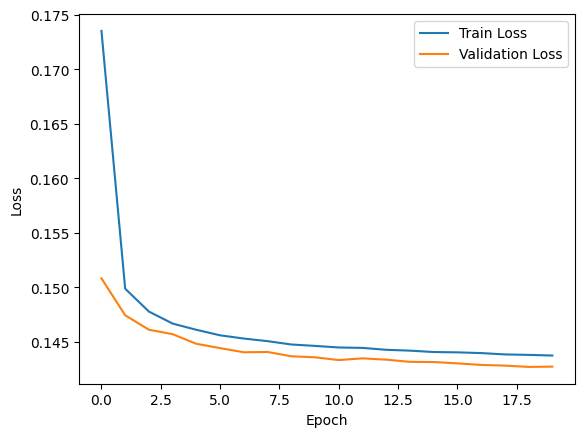

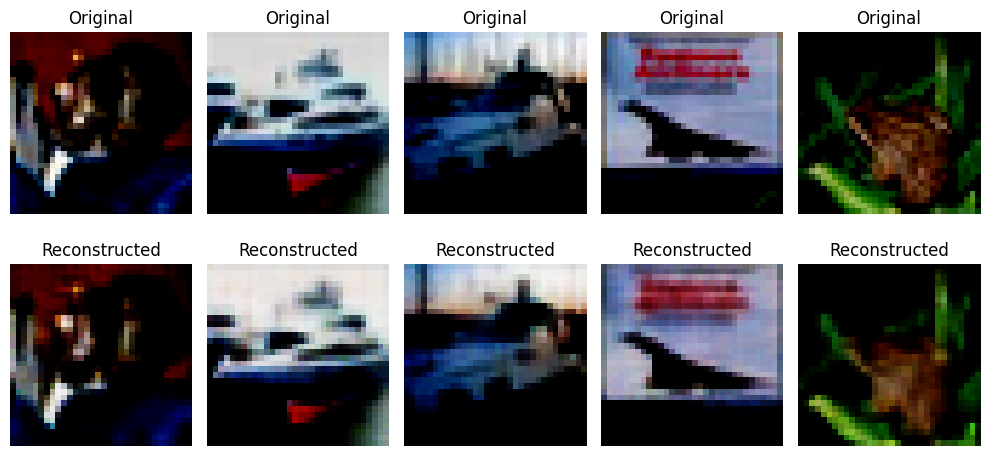

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms without augmentation for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Define data transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set into training and validation sets
# Using a 80-20 split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with early stopping
num_epochs = 20
patience = 5  # Number of epochs to wait before early stopping if validation loss doesn't improve
min_val_loss = float('inf')
no_improvement_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}...')
            break

torch.save(model.state_dict(), 'autoencoder_model.pth')


# Plotting loss curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


##Loading the trained model


In [ ]:
# Initialize the model with the same architecture

# Set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = Autoencoder().to(device)

#model = Autoencoder()

# Load the saved parameters into the model
# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('/content/autoencoder_model.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:

# Set the model to evaluation mode
model.eval()


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

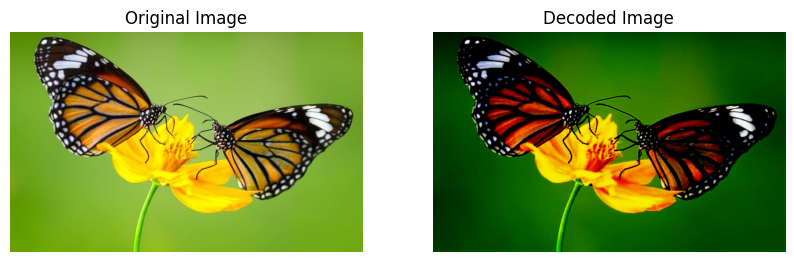

In [ ]:
import requests
import torch
import torchvision.transforms as transforms
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# URL of the image
image_url = "https://drive.google.com/uc?id=1oQXKAVfQgfFWlNVdxOIu4q6J9vQjXlTJ"

# Fetch the image data from the URL
response = requests.get(image_url)

# Open the image using PIL
image = Image.open(BytesIO(response.content))

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

# Function to display the original and decoded images
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.transpose(1, 2, 0))  # Transpose the image array
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.transpose(1, 2, 0))  # Transpose the image array
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_np.transpose(2, 0, 1), encoded_decoded_image)


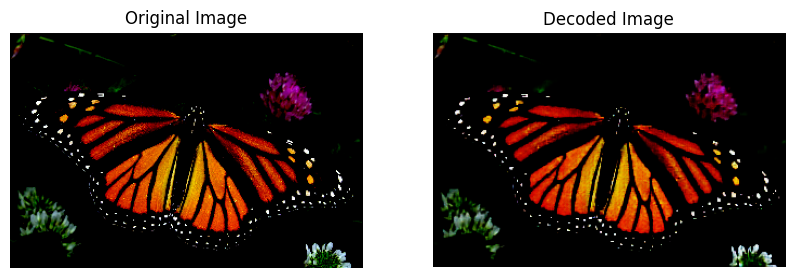

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/image1.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


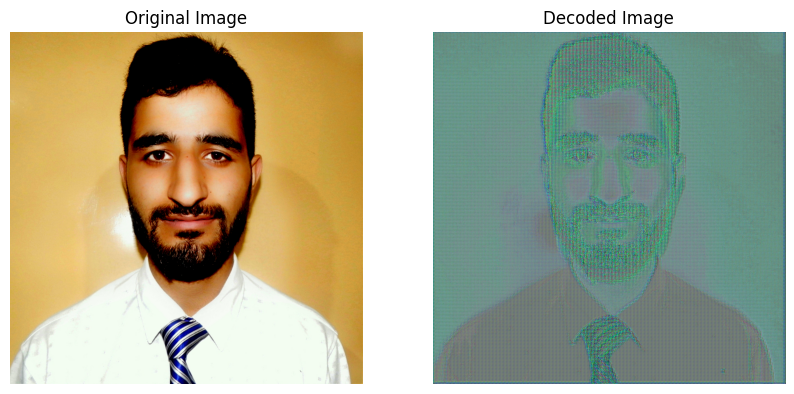

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/FORM PHOTO.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


Enter the path: /content/automobile1.jpeg


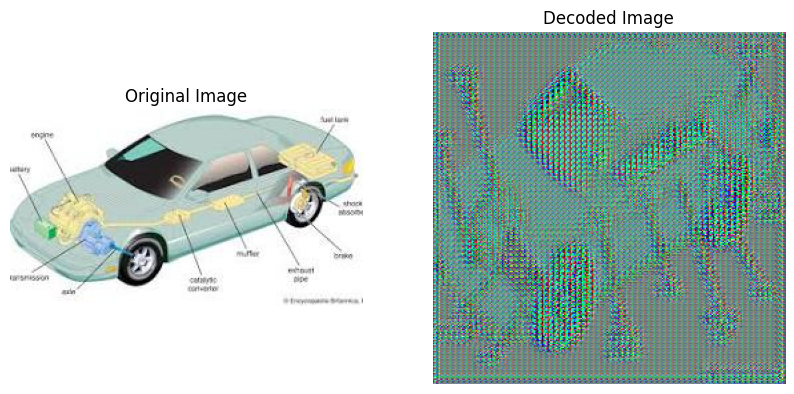

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation for the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a fixed size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

# Function to encode and decode the image
def encode_decode_image(image_path, model):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert RGBA to RGB if necessary (for PNG images with transparency)
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformation
    image_tensor = transform(image).unsqueeze(0)

    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return image, decoded_image_np

# Function to display the original and decoded images
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.transpose(1, 2, 0))
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Example usage
image_path = input("Enter the path: ")
# Load the model
# Load the saved parameters into the model
# Initialize the model with the same architecture
#model = Autoencoder().to(device)

#model.load_state_dict(torch.load('autoencoder_model.pth'))

# Encode and decode the image
original_image, decoded_image = encode_decode_image(image_path, model)

# Display the original and decoded images
display_images(original_image, decoded_image)


Enter the path: /content/automobile2.jpeg


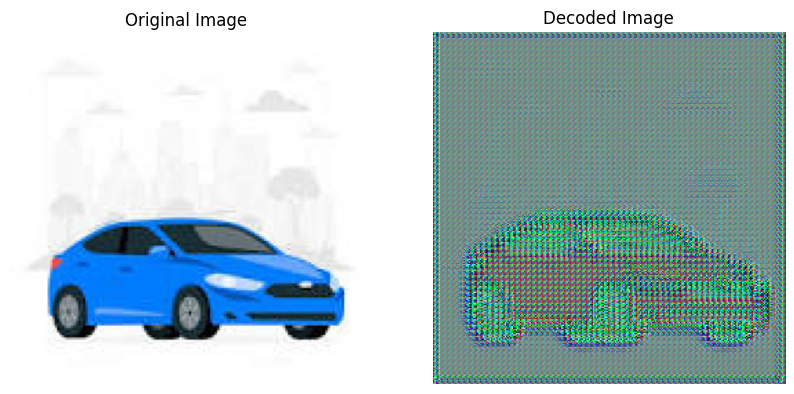

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation for the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a fixed size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

# Function to encode and decode the image
def encode_decode_image(image_path, model):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert RGBA to RGB if necessary (for PNG images with transparency)
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformation
    image_tensor = transform(image).unsqueeze(0)

    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return image, decoded_image_np

# Function to display the original and decoded images
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.transpose(1, 2, 0))
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Example usage
image_path = input("Enter the path: ")
# Load the model
# Load the saved parameters into the model
# Initialize the model with the same architecture
#model = Autoencoder().to(device)

#model.load_state_dict(torch.load('autoencoder_model.pth'))

# Encode and decode the image
original_image, decoded_image = encode_decode_image(image_path, model)

# Display the original and decoded images
display_images(original_image, decoded_image)


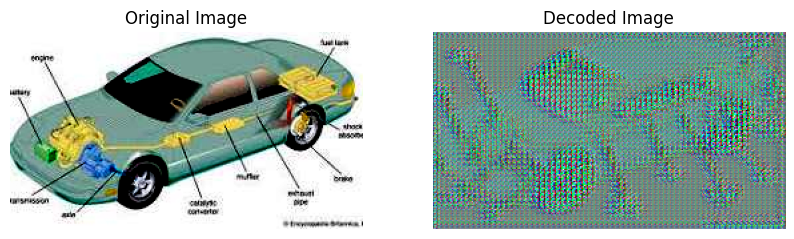

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/automobile1.jpeg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


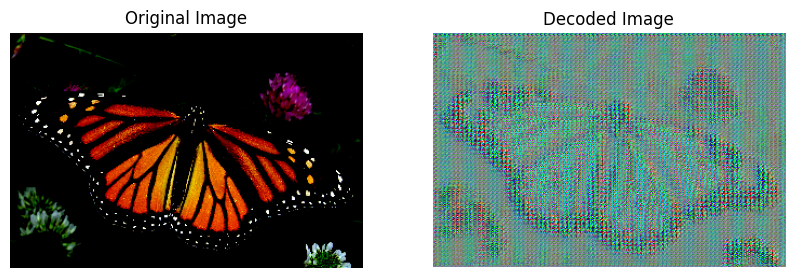

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/image1.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define RMSE loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

# Define a function for plotting training and validation loss
def plot_loss(train_loss, val_loss, test_loss=None):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.show()



100%|██████████| 170498071/170498071 [00:04<00:00, 42566026.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Train Loss: 0.2035, Val Loss: 0.1530
Epoch [2/20], Train Loss: 0.1517, Val Loss: 0.1481
Epoch [3/20], Train Loss: 0.1488, Val Loss: 0.1463
Epoch [4/20], Train Loss: 0.1475, Val Loss: 0.1454
Epoch [5/20], Train Loss: 0.1467, Val Loss: 0.1447
Epoch [6/20], Train Loss: 0.1463, Val Loss: 0.1445
Epoch [7/20], Train Loss: 0.1459, Val Loss: 0.1441
Epoch [8/20], Train Loss: 0.1455, Val Loss: 0.1435
Epoch [9/20], Train Loss: 0.1453, Val Loss: 0.1433
Epoch [10/20], Train Loss: 0.1451, Val Loss: 0.1435
Epoch [11/20], Train Loss: 0.1450, Val Loss: 0.1433
Epoch [12/20], Train Loss: 0.1449, Val Loss: 0.1430
Epoch [13/20], Train Loss: 0.1448, Val Loss: 0.1427
Epoch [14/20], Train Loss: 0.1447, Val Loss: 0.1430
Epoch [15/20], Train Loss: 0.1445, Val Loss: 0.1432
Epoch [16/20], Train Loss: 0.1445, Val Loss: 0.1426
Epoch [17/20], Train Loss: 0.1443, Val Loss: 0.1426
Epoch [18/20], Train Loss: 0.1443, V

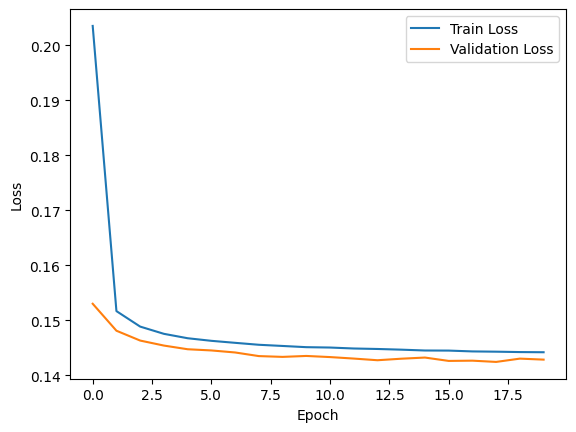

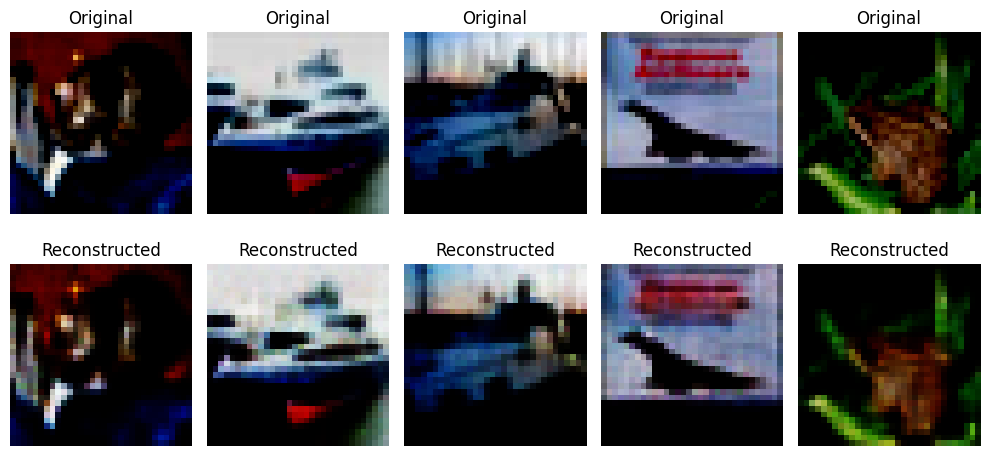

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms without augmentation for training
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

# Define data transforms for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set into training and validation sets
# Using a 80-20 split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with early stopping
num_epochs = 20
patience = 5  # Number of epochs to wait before early stopping if validation loss doesn't improve
min_val_loss = float('inf')
no_improvement_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}...')
            break

torch.save(model.state_dict(), 'autoencoder_model_with_Aug.pth')


# Plotting loss curves
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 5))
    num_images_to_show = 5
    for i in range(num_images_to_show):
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('/content/autoencoder_model_with_Aug.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

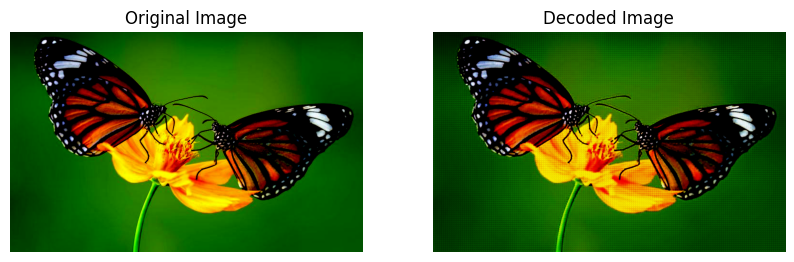

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/image2.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


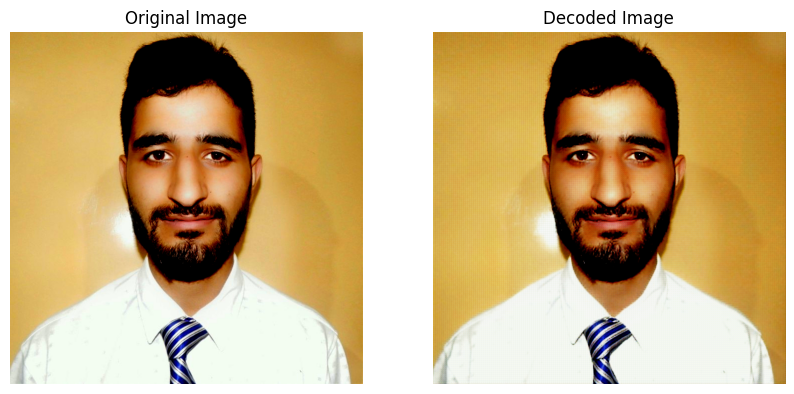

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/content/FORM PHOTO (3).jpg"

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Convert the image to a torch tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image_np).unsqueeze(0)

# Define a function to encode and decode the image
def encode_decode_image(image_tensor):
    # Encode the image
    encoded_image = model.encoder(image_tensor)

    # Decode the encoded image
    decoded_image = model.decoder(encoded_image)

    # Convert the decoded image tensor back to numpy array
    decoded_image_np = decoded_image.squeeze(0).detach().numpy()

    return decoded_image_np

# Encode and decode the image
encoded_decoded_image = encode_decode_image(image_tensor)

#
def display_images(original_image, decoded_image):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Original Image')
    plt.axis('off')

    # Plot decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
    plt.title('Decoded Image')
    plt.axis('off')

    plt.show()

# Display the original image and decoded image side by side
display_images(image_tensor, torch.tensor(encoded_decoded_image))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.Sigmoid()  # Output range [0, 1] for image pixels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Initialize the model with the same architecture
model = Autoencoder()

# Load the saved parameters into the model (map to CPU)
model.load_state_dict(torch.load('/content/autoencoder_model_with_Aug.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): C

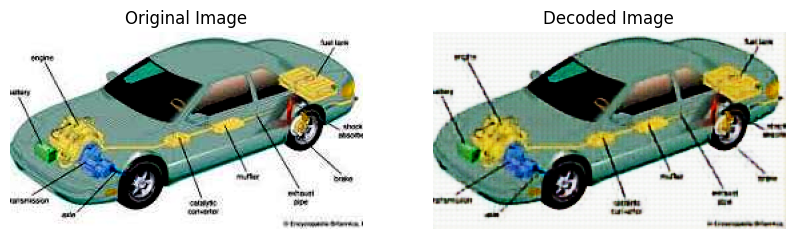

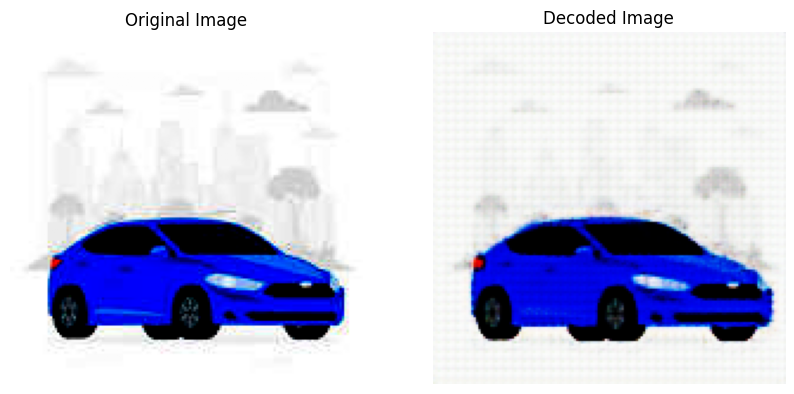

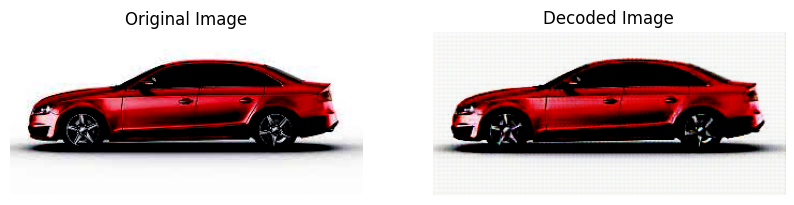

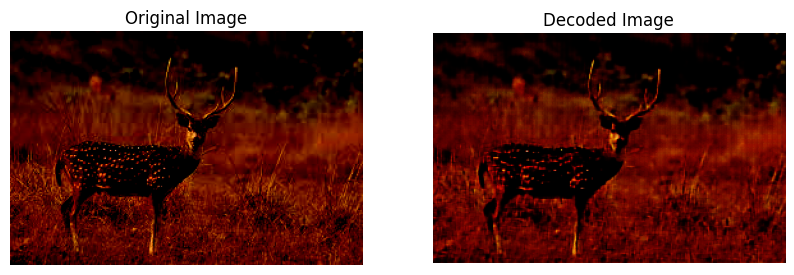

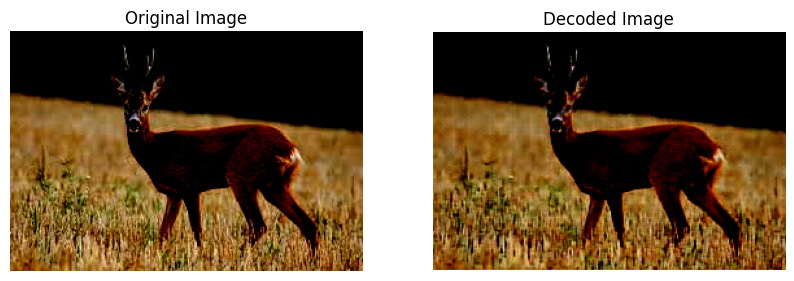

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Path to the image files
image_paths = ["/content/automobile1.jpeg", "/content/automobile2.jpeg", "/content/automobile3.jpeg","/content/deer1.jpeg","/content/deer3.jpeg"]

# Open and process each image
for image_path in image_paths:
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to a numpy array
    image_np = np.array(image)

    # Convert the image to a torch tensor and normalize it
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image_tensor = transform(image_np).unsqueeze(0)

    # Define a function to encode and decode the image
    def encode_decode_image(image_tensor):
        # Encode the image
        encoded_image = model.encoder(image_tensor)

        # Decode the encoded image
        decoded_image = model.decoder(encoded_image)

        # Convert the decoded image tensor back to numpy array
        decoded_image_np = decoded_image.squeeze(0).detach().numpy()

        return decoded_image_np

    # Encode and decode the image
    encoded_decoded_image = encode_decode_image(image_tensor)

    # Function to display images
    def display_images(original_image, decoded_image):
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Original Image')
        plt.axis('off')

        # Plot decoded image
        plt.subplot(1, 2, 2)
        plt.imshow(decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy())  # Permute to correct dimensions
        plt.title('Decoded Image')
        plt.axis('off')

        plt.show()

    # Display the original image and decoded image side by side
    display_images(image_tensor, torch.tensor(encoded_decoded_image))
